# Covid-19 Statistics

## Data Import & View

먼저 데이터 활용을 위한 여러 라이브러리들을 탑재합니다.  
Numpy, Pandas, Matplotlib, Seaborn과 분류 기계학습을 위한 SKlearn 라이브러리도 탑재해줍니다.

In [1]:
import numpy as np  # numpy 탑재
import pandas as pd  # pandas탑재
import seaborn as sns  # seaborn(데이터 시각화)탑재
import matplotlib.pyplot as plt  # matplotlib탑재
import os
import copy
import warnings
from os import system
from sklearn import tree
from sklearn.model_selection import train_test_split as TSplit
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.ensemble import RandomForestClassifier as RFor
from sklearn.metrics import accuracy_score as Acc
from sklearn.tree import export_graphviz

%matplotlib inline
warnings.filterwarnings('ignore') # warning 경고문을 보여주지 않음
plt.rc("font", family="Malgun Gothic") # plt 사용시 한글 폰트 맑은 고딕 지정

데이터는 캐글에 올라와 있는 자료들 중 Covid-19 Case Surveillance Public Use Dataset을 사용하였습니다.  
https://www.kaggle.com/arashnic/covid19-case-surveillance-public-use-dataset  
이 데이터는 2020년 1월1일부터 11월 19일까지 CDC에 보고된 미국인 확진자 840만명에 대한 데이터 입니다.  
데이터를 불러오고, 날짜 정보를 다루기 쉽도록 먼저 datetime 자료형으로 변환해 주겠습니다.  

to_datetime메서드까지만 사용하여 저장된 데이터를  
data1 = 시계열 정보를 반영하지 않는 분류 학습  
data2 = 월별로 구분하여 반영된 분류 학습  
을 위해 딥 카피로 복사하여줍니다.  
딥 카피를 사용하지 않으면 data 내용을 변경해도 data1내용이 함께 변경되기 때문입니다.  

to_datetime메서드만 사용하는 것과, strftime메서드까지 사용하는 것은 비슷해 보이지만 차이점이 있는데,  
to_datetime을 사용하면 timestamp형태로 저장된다는 것이고,  
strftime메서드는 이것을 원하는 규격의 문자로 다시 바꿔줍니다.  
이후 전처리와 학습을 위해서는 규격화된 문자형으로 저장하는것이 다루기 편리합니다.  

In [2]:
data = pd.read_csv('D:\Python\core-python-main\논문\COVID-19 Serveillence\COVID-19_Case_Surveillance_Public_Use_Data.csv', low_memory=False)

data.cdc_report_dt = pd.to_datetime(data.cdc_report_dt) # CDC 보고일을 datetime자료형으로 변환
data.pos_spec_dt = pd.to_datetime(data.pos_spec_dt) # 최초 양성 검체 수집일을 datetime자료형으로 변환
data.onset_dt = pd.to_datetime(data.onset_dt) # 발병일 datetime자료형으로 변환

data1 = copy.deepcopy(data) #시계열 정보 없이 분류학습
data2 = copy.deepcopy(data) #계절별 학습할 데이터

data.cdc_report_dt = data.cdc_report_dt.dt.strftime('%Y-%m-%d') # datetime중 년 월 일만 표시
data.pos_spec_dt = data.pos_spec_dt.dt.strftime('%Y-%m-%d')
data.onset_dt = data.onset_dt.dt.strftime('%Y-%m-%d')

data

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-11-10,2020-11-10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020-11-14,2020-11-10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
8405074,2020-10-22,NaN,NaN,Probable Case,Missing,30 - 39 Years,Unknown,No,Unknown,No,Missing
8405075,2020-10-25,NaN,NaN,Laboratory-confirmed case,Missing,30 - 39 Years,Unknown,Missing,Missing,Missing,Missing
8405076,2020-07-18,NaN,NaN,Laboratory-confirmed case,Missing,30 - 39 Years,Unknown,Missing,Missing,Missing,Missing
8405077,2020-11-19,NaN,NaN,Laboratory-confirmed case,Missing,30 - 39 Years,Unknown,Missing,Missing,Missing,Missing


데이터 정보를 살펴보면 8405079개의 데이터가 있는 것을 볼수 있습니다.  
11가지의 특성들이 있고, 자료형은 모두 object형입니다.  
cdc_report_dt - CDC 보고일  
pos_spec_dt - 최초 양성 검체 수집일  
onset_dt - 발병일  
current_status - 현 상태  
sex - 성별  
age_group - 연령대  
Race and ethnicity (combined) - 인종/민족  
hosp_yn - 입원 여부  
icu_yn - 중환자실 입실 여부  
death_yn - (COVID-19로 인한)사망 여부  
medcond_yn - 환자의 기저질환 또는 위험행동 여부  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 705.4+ MB


min()과 max()를 통해 자료의 시작일과 종료일을 확인합니다  

In [4]:
print("start date: ", data["cdc_report_dt"].min())
print("finish date: ", data["cdc_report_dt"].max())

start date:  2020-01-01
finish date:  2020-11-19


## Charts

데이터를 시각화해 보겠습니다.  
date 변수를 만들고 value_counts를 통해 일일 확진자가 몇명인지 종합합니다.  
이 data를 차트화 하면 일일 확진자수를 확인할 수 있는 그래프가 됩니다.  

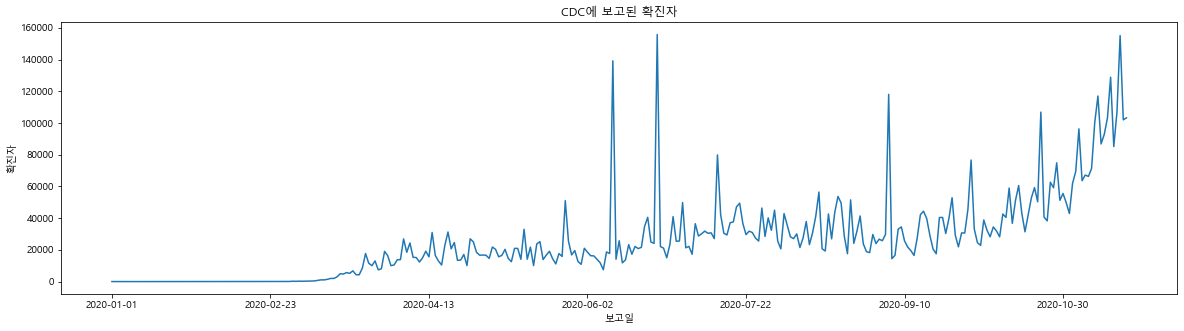

In [5]:
date = pd.DataFrame(data.value_counts('cdc_report_dt')) # CDC보고일마다 환자가 몇명 발생했는지 종합하여 date에 저장
date = date.sort_index() # date를 날짜순으로 정렬하여 저장
date[0].plot(title='CDC에 보고된 확진자', figsize=(20,5)) #선형그래프 표시
plt.xlabel("보고일") # x축 이름
plt.ylabel("확진자") # y축 이름
plt.show()

이번에는 특성중 하나인 인종을 활용하여 그래프를 그려보겠습니다.  
unique()를 통해 백인, 흑인, 황인등 매우 다양한 인종이 포함되어 있다는 것을 확인할 수 있습니다.  
특이한 점은 모두 Non-Hispanic이라는 문구가 붙어있는데,  
이는 히스패닉 인종의 기원이 매우 다양하기 때문으로, 조상중에 백인이나 흑인등이 포함되어있더라도  
"백인 조상의 혈통을 지닌 히스패닉" 이라고 인식하기 때문입니다.  
따라서 이 자료에서는 '히스패닉이 아닌 흑인'과 '흑인 혈통을 지닌 히스패닉'의 방식으로 구분하고 있습니다.  

In [6]:
data['Race and ethnicity (combined)'].unique()

array(['Black, Non-Hispanic', 'White, Non-Hispanic', 'Unknown',
       'Asian, Non-Hispanic',
       'American Indian/Alaska Native, Non-Hispanic',
       'Multiple/Other, Non-Hispanic', 'Missing',
       'Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'Hispanic/Latino', nan], dtype=object)

결측치인 Unknown을 제외하면, 백인, 히스패닉, 흑인 순서대로 많습니다. 

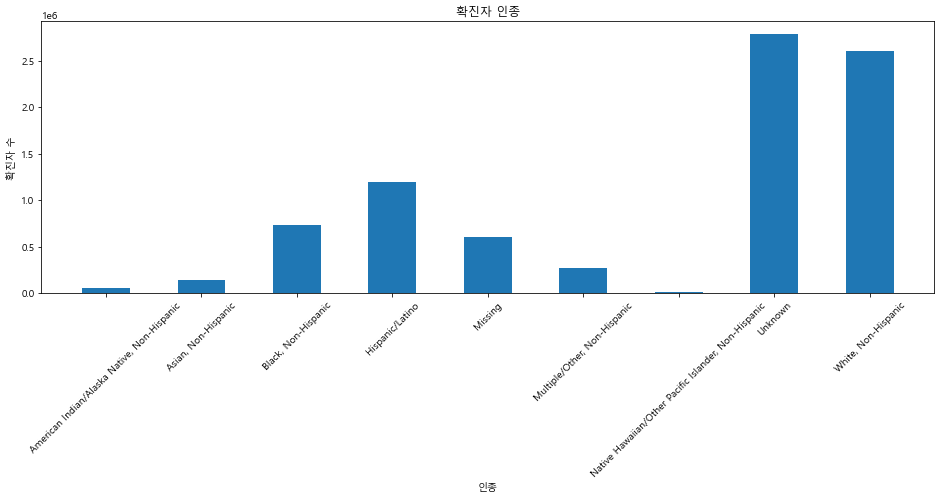

In [7]:
race = pd.DataFrame(data.value_counts('Race and ethnicity (combined)')) # 인종별 환자가 몇명 발생했는지 확인하여 데이터 프레임 삽입
race = race.sort_index() # 인덱스의 이름(알파벳) 순서대로 정렬하여 저장
plt.figure(figsize=(16,5)) # 그래프 크기 조정
plt.bar(range(len(race)), race[0], width=0.5) # 바 그래프 생성, x축은 race의 인덱스 갯수만큼 간격, y축은 race의 내용(칼럼이름 0) = 확진자 보고수량
plt.title("확진자 인종") # 제목
plt.xlabel("인종") # x축 이름
plt.ylabel("확진자 수") # y축 이름
plt.xticks(range(len(race)), race.index, rotation = 45) # x축 단위간격들의 이름이 너무 길기 때문에, 45도로 돌려서 표기
plt.show() # show명령으로 표시하면 계산 내용은 감춤

연령대의 경우에는 20, 30대가 가장 많았습니다.

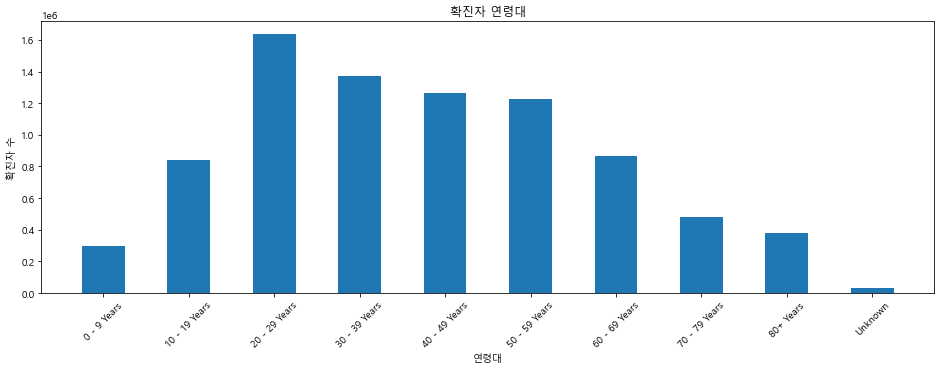

In [8]:
age = pd.DataFrame(data.value_counts('age_group')) # 연령별 환자가 몇명 발생했는지 확인하여 데이터 프레임 삽입
age = age.sort_index() # 연령 순서대로 정렬하여 저장
plt.figure(figsize=(16, 5)) # 그래프 크기 조정
plt.bar(range(len(age)), age[0], width=0.5) # 바 그래프 생성, x축은 age의 인덱스 갯수만큼 간격, y축은 age의 내용(칼럼이름 0) = 확진자 보고수량
plt.title("확진자 연령대") # 제목
plt.xlabel("연령대") # x축 이름
plt.ylabel("확진자 수") # y축 이름
plt.xticks(range(len(age)), age.index, rotation = 45) # x축 단위간격들의 이름이 너무 길기 때문에, 45도로 돌려서 표기
plt.show() # show명령으로 표시하면 계산 내용은 감춤

성별, 입원, 사망률의 비율입니다.

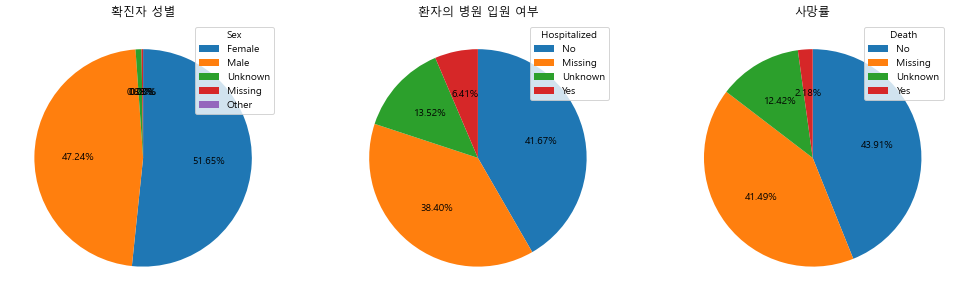

In [9]:
sex = pd.DataFrame(data.value_counts('sex')) # 성별 별 확진자수
hospital = pd.DataFrame(data.value_counts('hosp_yn')) # 확진자의 병원 입원 여부
death = pd.DataFrame(data.value_counts('death_yn')) # 사망자 수
plt.figure(figsize=(17,5)) # 파이차트 크기

plt.subplot(131) # 1행 3열 크기 1번칸
plt.title("확진자 성별") # 제목
plt.pie(sex[0], labels=None, autopct='%.2f%%', startangle=90, counterclock=False) # 내용(컬럼 0)삽입, 차트에는 레이블 없음, 소수점2자리까지, 각도90도
plt.legend(title='Sex', labels=sex.index, loc='upper right') # 범례 내용 - 제목, 인덱스목록(범주들 이름), 범례 위치

plt.subplot(132) # 1행 3열 크기 2번칸
plt.title("환자의 병원 입원 여부")
plt.pie(hospital[0], labels=None, autopct='%.2f%%', startangle=90, counterclock=False)
plt.legend(title='Hospitalized', labels=hospital.index, loc='upper right')

plt.subplot(133)
plt.title("사망률") # 1행 3열 크기 3번칸
plt.pie(death[0], labels=None, autopct='%.2f%%', startangle=90, counterclock=False)
plt.legend(title='Death', labels=death.index, loc='upper right')

## Data Preprocessing

데이터를 가지고 학습하려면 전처리가 적절히 진행 되어야 합니다.  
결측치가 얼마나 있는지 확인하겠습니다.  

In [10]:
print(data.isnull().sum())

cdc_report_dt                          0
pos_spec_dt                      5534290
onset_dt                         4009122
current_status                         0
sex                                   18
age_group                             89
Race and ethnicity (combined)          7
hosp_yn                                0
icu_yn                                 0
death_yn                               0
medcond_yn                             0
dtype: int64


학습할 데이터에서 양성검체 수집일과 증상발현일(발병일)은 결측치가 너무 많아(50% 이상) 삭제하였습니다.  
(CDC 보고일로 대체 가능)  
기저질환 여부는 이상값이 매우 많고 다양하여 코로나와의 직접적인 상관관계를 검증할 수 없으므로 삭제하였습니다.  

In [11]:
data1 = data1.drop(["pos_spec_dt", "onset_dt", "medcond_yn"], axis=1)
data2 = data2.drop(["pos_spec_dt", "onset_dt", "medcond_yn"], axis=1)

디시전 트리모델이 학습하기 쉽도록 모든 내용을 숫자형으로 바꿔주는 Label Encoding을 진행합니다.  
data1은 시계열 정보 없이 분류 학습을 진행할 데이터 세트이므로, 시계열 정보는 전처리 하지 않습니다.  
또한 Unknown, Missing, Other등의 이상값 및 NaN으로 표시된 결측치를 포함한 행은 모두 제거합니다.  

In [12]:
data1['current_status'] = data1['current_status'].map({
    'Laboratory-confirmed case' : 0,
    'Probable Case' : 1,
})
data1['sex'] = data1['sex'].map({
    'Male' : 0,
    'Female' : 1,
})

# 문자열 변환을 위해 각 연령대를 의미하는 숫자로 변환
data1['age_group'] = data1['age_group'].map({
    '0 - 9 Years' : 0,
    '10 - 19 Years' : 10,
    '20 - 29 Years' : 20,
    '30 - 39 Years' : 30,
    '40 - 49 Years' : 40,
    '50 - 59 Years' : 50,
    '60 - 69 Years' : 60,
    '70 - 79 Years' : 70,
    '80+ Years' : 80,
})

data1['Race and ethnicity (combined)'] = data1['Race and ethnicity (combined)'].map({
    'White, Non-Hispanic' : 0,
    'Hispanic/Latino' : 1,
    'Black, Non-Hispanic' : 2,
    'Asian, Non-Hispanic' : 3,
    'Multiple/Other, Non-Hispanic' : 4,
    'Native Hawaiian/Other Pacific Islander, Non-Hispanic' : 5,
    'American Indian/Alaska Native, Non-Hispanic' : 6,
})
data1['hosp_yn'] = data1['hosp_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data1['icu_yn'] = data1['icu_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data1['death_yn'] = data1['death_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data1 = data1.replace('Unknown', np.NaN)
data1 = data1.replace('Missing', np.NaN)
data1 = data1.replace('Other', np.NaN)
data1 = data1.dropna(axis = 0) 
#자료 내부에 이상값을 전부 제외 = nan

data2는 시계열 정보를 포함하여 계절별로 학습할 것이기 때문에, 월 정보만 strftime를 통해 변환합니다.  
월만 남겨두고 숫자형으로 변환하여 사용하고, 나머지 조건은 data1과 똑같습니다.  

In [13]:
data2.cdc_report_dt = data2.cdc_report_dt.dt.strftime('%m')

In [14]:
data2['cdc_report_dt'] = data2['cdc_report_dt'].map({
    '01' : 1,
    '02' : 2,
    '03' : 3,
    '04' : 4,
    '05' : 5,
    '06' : 6,
    '07' : 7,
    '08' : 8,
    '09' : 9,
    '10' : 10,
    '11' : 11,
}) # 월 표시를 문자 > 숫자로
data2['current_status'] = data2['current_status'].map({
    'Laboratory-confirmed case' : 0,
    'Probable Case' : 1,
})
data2['sex'] = data2['sex'].map({
    'Male' : 0,
    'Female' : 1,
})
data2['age_group'] = data2['age_group'].map({
    '0 - 9 Years' : 0,
    '10 - 19 Years' : 10,
    '20 - 29 Years' : 20,
    '30 - 39 Years' : 30,
    '40 - 49 Years' : 40,
    '50 - 59 Years' : 50,
    '60 - 69 Years' : 60,
    '70 - 79 Years' : 70,
    '80+ Years' : 80,
}) # 문자열 변환을 위해 각 연령대를 의미하는 숫자로 변환
data2['Race and ethnicity (combined)'] = data2['Race and ethnicity (combined)'].map({
    'White, Non-Hispanic' : 0,
    'Hispanic/Latino' : 1,
    'Black, Non-Hispanic' : 2,
    'Asian, Non-Hispanic' : 3,
    'Multiple/Other, Non-Hispanic' : 4,
    'Native Hawaiian/Other Pacific Islander, Non-Hispanic' : 5,
    'American Indian/Alaska Native, Non-Hispanic' : 6,
})
data2['hosp_yn'] = data2['hosp_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data2['icu_yn'] = data2['icu_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data2['death_yn'] = data2['death_yn'].map({
    'No' : 0,
    'Yes' : 1,
})
data2 = data2.replace('Unknown', np.NaN)
data2 = data2.replace('Missing', np.NaN)
data2 = data2.replace('Other', np.NaN)
data2 = data2.dropna(axis = 0) 
#자료 내부에 이상값을 전부 제외

다시 결측치를 확인해 보면 모두 없어진 것을 확인할 수 있습니다.

In [15]:
print(data1.isnull().sum())
print(data2.isnull().sum())

cdc_report_dt                    0
current_status                   0
sex                              0
age_group                        0
Race and ethnicity (combined)    0
hosp_yn                          0
icu_yn                           0
death_yn                         0
dtype: int64
cdc_report_dt                    0
current_status                   0
sex                              0
age_group                        0
Race and ethnicity (combined)    0
hosp_yn                          0
icu_yn                           0
death_yn                         0
dtype: int64


## Machine Learning Classification

이제 학습을 진행해 보겠습니다.  
사용할 모델은 지도학습 - 분류의 랜덤포레스트 알고리즘 입니다.  
랜덤 포레스트 알고리즘은 디시전 트리를 여러개 만들어 종합하는 앙상블 기법을 사용합니다.  
먼저 데이터를 학습용과 테스트용으로 분할합니다 (3:1 비율)  
data1의 경우 시계열 정보를 활용하지 않기 때문에, CDC보고일 특성도 제외시킵니다.  

In [16]:
train_data1 = data1.drop(['cdc_report_dt', 'death_yn'], axis=1) # 시계열 특성과 레이블인 사망여부 제외
target_data1 = data1['death_yn'] # 레이블은 따로 저장함

x_train, x_test, y_train, y_test = TSplit(train_data1, target_data1, random_state=42)
# 각각 75 : 25 비율로 랜덤분할하여 넣고 랜덤시드는 42 고정

print(train_data1.shape, x_train.shape, x_test.shape)

(590974, 6) (443230, 6) (147744, 6)


데이터 분할이 완료되었으니, 학습 세트를 이용하여 랜덤포레스트 모델을 학습시켜 보겠습니다.  
랜덤 포레스트 모델을 디시전 트리를 여러개 만들어 사용하는데,  
n_estimators 속성을 사용하면 디시전 트리를 몇개 만들어 종합할 것인지 정할 수 있습니다.  

In [17]:
forest1 = RFor(n_estimators = 20) # 랜덤포레스트 가지갯수 20개
forest1.fit(x_train, y_train) # 학습하자!

forest1.predict(x_test) # 학습 세트로 학습된 모델에 테스트 세트 사용

print('training set accuracy:', forest1.score(x_train, y_train)) # train(75%)셋 예측 정확도
print('test set accuracy:', forest1.score(x_test, y_test)) # test(25%)셋의 예측 정확도

training set accuracy: 0.9525708999842069
test set accuracy: 0.9520928091834524


학습 결과 훈련세트의 예측 정확도와 테스트세트의 예측 정확도가 매우 유사합니다.  
이런 경우, 훈련세트로 학습된 랜덤 포레스트 모델이 잘 일반화 되었다고 볼 수 있습니다.  

학습된 모델의 feature_importances와 모델이 예측한 사망률을 시각화 해 보겠습니다.  
feature_importances는 학습에 사용된 특성의 중요도로써, 모델 학습에 얼마나 영향을 끼쳤는지 나타냅니다.  
현재 중요도는 중환자실(집중치료실) 입실 여부가 가장 크고, 그 다음으로 연령대와 병원 입원 여부가 뒤따랐습니다.  

Feature: 0, Score: 0.0010
Feature: 1, Score: 0.0061
Feature: 2, Score: 0.2496
Feature: 3, Score: 0.0195
Feature: 4, Score: 0.2553
Feature: 5, Score: 0.4685


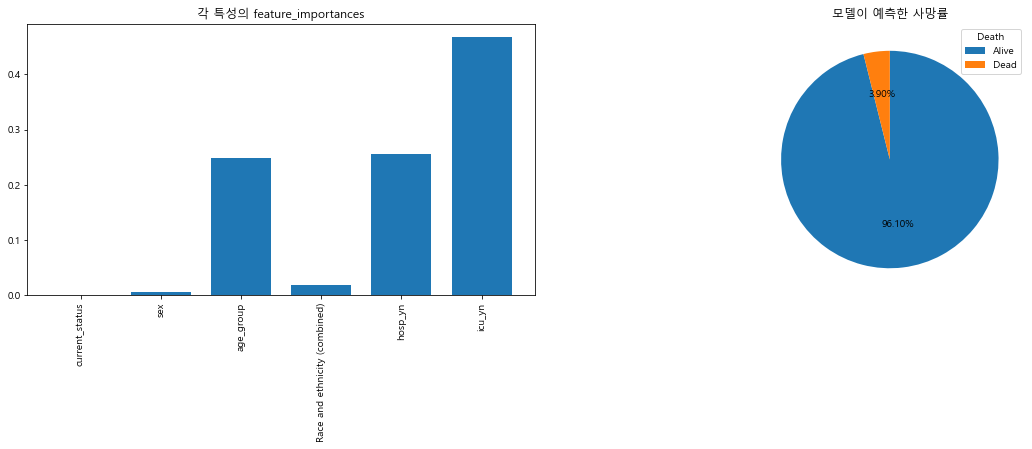

In [18]:
fimportance1 = forest1.feature_importances_ # 트리에서 각 요소별 중요도 뽑기
fcolname1 = x_train.columns.to_numpy() # x_train의 칼럼명을 뽑아와서 넣어주자
for x,y in enumerate(fimportance1):
    print('Feature: %0d, Score: %.4f' % (x,y)) # 중요도를 수치로 보여준다

plt.figure(figsize=(20,5)) # 파이차트 크기
plt.subplot(121) # 1행 2열 크기 1번칸
plt.title("각 특성의 feature_importances")
plt.bar(range(len(fimportance1)), fimportance1, width=0.75) # 바 갯수는 중요도 갯수만큼, 수치는 중요도만큼
plt.xticks(range(len(fcolname1)), fcolname1, rotation = 90) # x축 단위간격들의 이름이 너무 길기 때문에, 90도로 돌려서 표기

# 학습되어 있는 모델에 데이터를 넣어보자.
death1 = pd.DataFrame(pd.DataFrame(forest1.predict(train_data1))[0].value_counts())
plt.subplot(122) # 1행 2열 크기 2번칸
plt.title("모델이 예측한 사망률")
plt.pie(death1[0], labels=None, autopct='%.2f%%', startangle=90, counterclock=False)
plt.legend(title='Death', labels=["Alive", "Dead"], loc='upper right')

# 기존 데이터 사망률 2.18

## Machine Learning - Time series

이번에는 시계열 정보를 활용하여 학습을 진행해 보겠습니다.  
CDC보고일을 drop시키지 않은 데이터를 다시 분할하여 사용해 주어야 합니다.  

In [19]:
train_data2 = data2.drop(['death_yn'], axis=1) # 시계열 특성과 레이블인 사망여부 제외
target_data2 = data2['death_yn'] # 레이블은 따로 저장함

x_train, x_test, y_train, y_test = TSplit(train_data2, target_data2, random_state=42)
# 각각 75 : 25 비율로 랜덤분할하여 넣고 랜덤시드는 42 고정

print(train_data2.shape, x_train.shape, x_test.shape, target_data2.shape)

(590974, 7) (443230, 7) (147744, 7) (590974,)


이번에도 똑같이 20개의 디시전 트리를 앙상블하여 학습합니다.

In [20]:
forest2 = RFor(n_estimators = 20) # 랜덤포레스트 가지갯수 20개
forest2.fit(x_train, y_train) # 학습하자!

forest2.predict(x_test) # 학습 세트로 학습된 모델에 테스트 세트 사용

print('training set accuracy:', forest2.score(x_train, y_train)) # train(75%)셋 예측 정확도
print('test set accuracy:', forest2.score(x_test, y_test)) # test(25%)셋의 예측 정확도

training set accuracy: 0.9568327956140154
test set accuracy: 0.9552536820446177


feature_importances를 확인하면 시계열 특성(CDC보고일)이 4번째로 중요하게 학습되었다는 것을 확인할 수 있습니다.  
모델의 학습에 있어서 시계열 정보가 일정량 이상의 영향력을 가지고 있다는 것을 보여줍니다.  

Feature: 0, Score: 0.1033
Feature: 1, Score: 0.0020
Feature: 2, Score: 0.0089
Feature: 3, Score: 0.2667
Feature: 4, Score: 0.0287
Feature: 5, Score: 0.2601
Feature: 6, Score: 0.3302


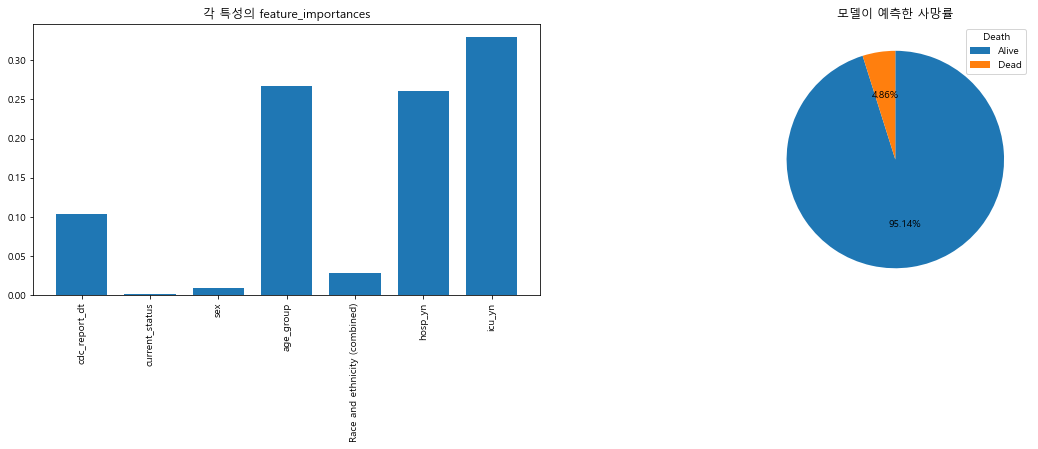

In [21]:
fimportance2 = forest2.feature_importances_ # 트리에서 각 요소별 중요도 뽑기
fcolname2 = x_train.columns.to_numpy() # x_train의 칼럼명을 뽑아와서 넣어주자

for x,y in enumerate(fimportance2):
    print('Feature: %0d, Score: %.4f' % (x,y)) # 중요도를 수치로 보여준다

plt.figure(figsize=(20,5)) # 파이차트 크기
plt.subplot(121) # 1행 2열 크기 1번칸
plt.title("각 특성의 feature_importances")
plt.bar(range(len(fimportance2)), fimportance2, width=0.75) # 바 갯수는 중요도 갯수만큼, 수치는 중요도만큼
plt.xticks(range(len(fcolname2)), fcolname2, rotation = 90) # x축 단위간격들의 이름이 너무 길기 때문에, 90도로 돌려서 표기

# 학습되어 있는 모델에 데이터를 넣어보자.
death2 = pd.DataFrame(pd.DataFrame(forest2.predict(train_data2))[0].value_counts())
                      
plt.subplot(122) # 1행 2열 크기 2번칸
plt.title("모델이 예측한 사망률")
plt.pie(death2[0], labels=None, autopct='%.2f%%', startangle=90, counterclock=False)
plt.legend(title='Death', labels=["Alive", "Dead"], loc='upper right')

# 기존 데이터 사망률 2.18

본래 데이터를 계절별로 분류하고 forest2모델에 predict하여 계절별 사망률 예측을 평가하고자 하였으나,  
2020년 1~2월 등은 코로나 전파 초창기로 인해 학습할 수 있는 감염 인원 모집단이 매우 적어  
사망률 예측치가 매우 과대해지는 경우(25%)가 존재하여 해당 내용은 제외하였습니다.

감사합니다!